# Applied Data Science Capstone - Battle of Neighborhood
## Searching for best location for coffee shop startup
---
## Item 1 -Problem Statement and Data Source
---

### Problem Statement

Someone has just finished her barista training, and is thinking of opening a coffee shop around the city of London.
The problem is where would be the best location to start a coffee shop?

There are few things to consider when chosing the best location for coffee shop:

* whether that place has enough population

* whether that place is overcrowded by coffee shops

* whether that place has huge competition from famous coffee shops

* whether the rental is affordable

### Source of Data

In order to complete the analysis, some source of data is required.

Firstly, we decided to use neighborhoods within boroughs in city of London as the location. 

The **list of neighborhoods and boroughs** are at below location:

https://en.wikipedia.org/wiki/List_of_areas_of_London

The data for **distribution of population** surrounding neighborhoods in London is as per below location:

https://data.london.gov.uk/dataset/detailed-ethnicity-by-age---sex-ward-tools---2011-census--

The data for **rental** of small shops around neighborhoods in London is as per below location:

https://www.london.gov.uk/file/8008/download?token=25cnLidQ

The data is collected and preprocessed into an excel file before loading into notebook for data analysis

---

## Item 2 - Data Analysis using Notebook
---

### Insert necessary python library

In [124]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import DBSCAN from clustering stage
from sklearn.cluster import DBSCAN 

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

In [12]:
!pip install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Insert excel datasheet into notebook

In [183]:
# The code was removed by Watson Studio for sharing.

In [184]:
# read the excel file from IBM database
London_data.head()


,Neighborhood,Borough,City,Postcode,Population,Rental per m2
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,15704,300
1,Balham,Wandsworth[13],LONDON,SW12,14751,969
2,Barnes,Richmond upon Thames[15],LONDON,SW13,10299,700
3,Barnsbury,Islington[17],LONDON,N1,12201,2368
4,Bayswater,Westminster[19],LONDON,W2,10300,950


### Insert coordinates for each data based on neighborhood address

In [186]:
#gather the coordinate for each borough
London_data['longitude']=''
London_data['latitude']=''

i=0
for i in London_data.index:
    address = London_data['Neighborhood'][i]+','+ London_data['City'][i]
    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    London_data.iloc[i,London_data.columns.get_loc('longitude')]=longitude
    London_data.iloc[i,London_data.columns.get_loc('latitude')]=latitude
    i=i+1

London_data.head()

,Neighborhood,Borough,City,Postcode,Population,Rental per m2,longitude,latitude
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,15704,300,0.11405,51.4876
1,Balham,Wandsworth[13],LONDON,SW12,14751,969,-0.150364,51.4456
2,Barnes,Richmond upon Thames[15],LONDON,SW13,10299,700,-0.238744,51.4719
3,Barnsbury,Islington[17],LONDON,N1,12201,2368,-0.114735,51.5389
4,Bayswater,Westminster[19],LONDON,W2,10300,950,-0.188385,51.5123


In [187]:
# The code was removed by Watson Studio for sharing.

### Create a map for all the neighborhoods in London

In [17]:
# create map of London using latitude and longitude values
address1 = 'London'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address1)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

map_London = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(London_data['latitude'], London_data['longitude'], London_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)  
    
map_London

The geograpical coordinate of London are 51.5073219, -0.1276474.


### Getting all the recommended venues for neighborhoods in London using Foursquare API 

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

London_venues = getNearbyVenues(names=London_data['Neighborhood'],
                                   latitudes=London_data['latitude'],
                                   longitudes=London_data['longitude']
                                  )

Abbey Wood
Balham
Barnes
Barnsbury
Bayswater
Beckton
Bellingham
Blackheath
Bloomsbury
Bounds Green
Brockley
Brompton
Brunswick Park
Cann Hall
Canonbury
Charlton
Childs Hill
Church End
Church End
Clerkenwell
Colindale
Colliers Wood
Crofton Park
Crouch End
Crystal Palace
Custom House
Dalston
Dollis Hill
Earlsfield
East Dulwich
East Finchley
East Sheen
Finsbury Park
Forest Hill
Fortis Green
Gipsy Hill
Golders Green
Gospel Oak
Grove Park
Grove Park
Hackney Central
Haggerston
Harlesden
Harringay
Hendon
Herne Hill
Highgate
Holloway
Hornsey
Hoxton
Kensal Green
Kentish Town
Kenton
Kilburn
King's Cross
Ladywell
Lea Bridge
Leyton
Leytonstone
Limehouse
Little Ilford
Little Venice
Longlands
Maida Vale
Manor Park
Merton Park
Mill Hill
Millwall
Muswell Hill
New Cross
Newington
Norbury
Nunhead
Oval
Palmers Green
Peckham
Plumstead
Queen's Park
Raynes Park
Rotherhithe
Sands End
Selhurst
Seven Sisters
Shadwell
Snaresbrook
South Norwood
Southfields
Southgate
St James's
Stockwell
Stonebridge
Stroud Green


In [23]:
London_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.487621,0.114050,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.487621,0.114050,Bostal Gardens,51.486670,0.110462,Playground
2,Abbey Wood,51.487621,0.114050,Abbey Wood Caravan Club,51.485502,0.120014,Campground
3,Balham,51.445645,-0.150364,We Brought Beer,51.444324,-0.150656,Beer Store
4,Balham,51.445645,-0.150364,M1LK,51.444450,-0.150913,Coffee Shop


In [24]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()


,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio
0,Abbey Wood,0,0,0,0

In [25]:
London_grouped = London_onehot.groupby('Neighborhood').sum().reset_index()
London_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Science Building,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio
0,Abbey Wood,0,0,0,0

### Narrow down the list of recommended venues to coffee shops

In [26]:
London_coffee=London_grouped.loc[:, ['Neighborhood','Coffee Shop']].set_index('Neighborhood')
London_coffee.head()

,Coffee Shop
Neighborhood,
Abbey Wood,0
Balham,7
Barnes,1
Barnsbury,1
Bayswater,4


### Plot a bar chart to show the quantity of recommended coffee shops around neighborhoods of London

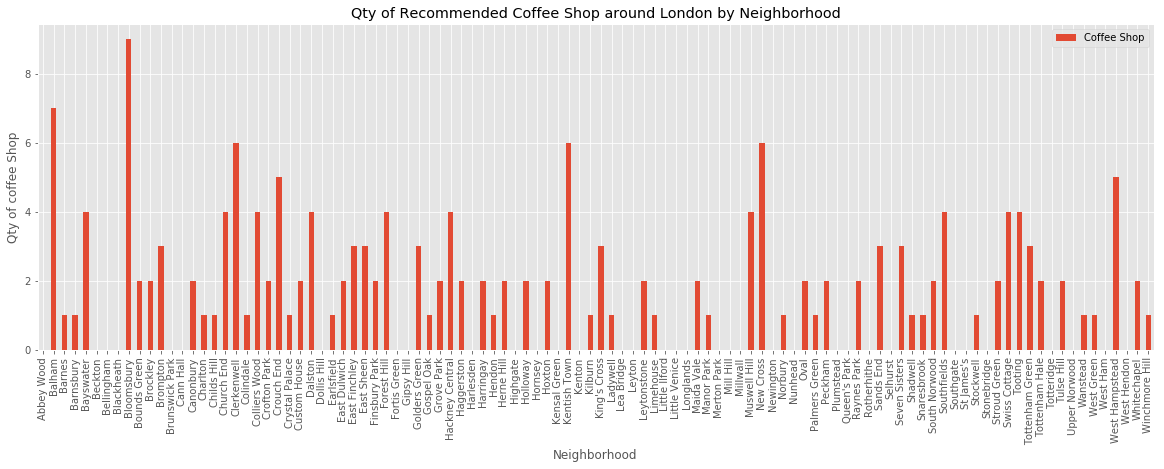

In [27]:
London_coffee.plot(kind='bar', figsize=(20, 6))

plt.title('Qty of Recommended Coffee Shop around London by Neighborhood')
plt.ylabel('Qty of coffee Shop')
plt.xlabel('Neighborhood')

plt.show()

From the bar chart the quantity of coffee shops in neighborhoods are around 1-2, with highest 9 coffee shops in 1 area.

### Check which coffee shops has the most outlets

In [28]:
London_coffee2=London_venues.loc[London_venues['Venue Category']=='Coffee Shop']
London_coffee2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Balham,51.445645,-0.150364,M1LK,51.444450,-0.150913,Coffee Shop
5,Balham,51.445645,-0.150364,Brickwood Coffee & Bread,51.444509,-0.151127,Coffee Shop
11,Balham,51.445645,-0.150364,Camden Coffee House,51.443271,-0.152967,Coffee Shop
27,Balham,51.445645,-0.150364,South River Coffee,51.446389,-0.149749,Coffee Shop
35,Balham,51.445645,-0.150364,Costa Coffee,51.444126,-0.152403,Coffee Shop


In [29]:
London_topcoffee = pd.DataFrame(London_coffee2.Venue.value_counts().reset_index().values, columns=['Venue', 'Count'])
#From here we know which recommended coffee shop has the most outlets
London_topcoffee.head()


,Venue,Count
0,Costa Coffee,32
1,Starbucks,16
2,Caffè Nero,11
3,Brickwood Coffee & Bread,3
4,Urban Baristas,2


From here we have a list of coffee shops and quantity of its outlets

Combining coffee shop with outlets less than 3 into 1 category

In [30]:
# Reprocess by grouping other coffee shops
distribution = London_topcoffee.loc[London_topcoffee['Count']>=3]
others =  London_topcoffee.loc[London_topcoffee['Count'] <= 2, 'Count'].sum()
distribution = distribution.append(pd.Series(['Others with less than 3 outlets', others], index=['Venue','Count']), ignore_index=True).set_index('Venue')
distribution

,Count
Venue,
Costa Coffee,32
Starbucks,16
Caffè Nero,11
Brickwood Coffee & Bread,3
Others with less than 3 outlets,113


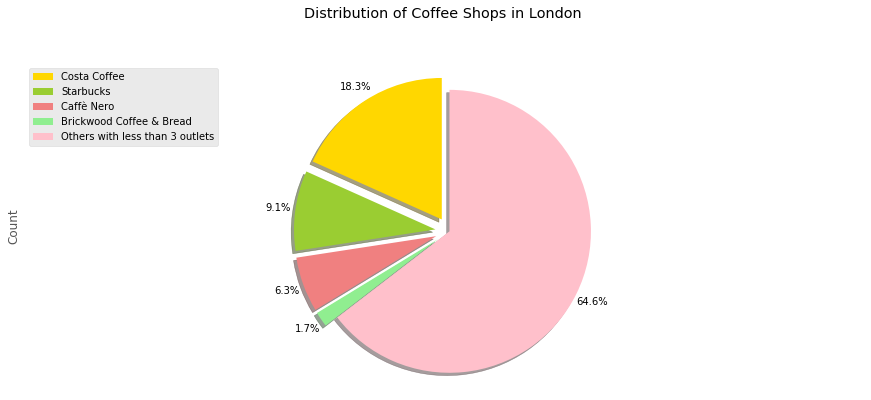

In [31]:
#plot a pie chart to know the distribution of coffee shop

colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightgreen','pink']
explode_list = [0.1, 0.1, 0.1, 0.1, 0] # ratio for each continent with which to offset each wedge.

distribution['Count'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Distribution of Coffee Shops in London', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=distribution.index, loc='upper left') 

plt.show()

From above we can understand which coffee shops has the most outlets, and we can summarize the top 4 coffee shop brand in London.

### Plot a bar chart showing distribution of top 4 coffee shops in London

In [32]:
# one hot encoding
London_onehot2 = pd.get_dummies(London_coffee2[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot2['Neighborhood'] = London_coffee2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot2.columns[-1]] + list(London_onehot2.columns[:-1])
London_onehot2 = London_onehot2[fixed_columns]

London_grouped2 = London_onehot2.groupby('Neighborhood').sum().reset_index()
London_grouped2.head()

,Neighborhood,Allpress Espresso Roastery & Cafe,Arlo & Moe,Arro Coffee - the Temple of Coffee,Artisan Coffee East Sheen,Attendant,Barebrew,Beans & Barley,Black Sheep Coffee,Blighty Tottenham,BooKafé,Brew + Wild,Brew for Two,Brickwood Coffee & Bread,Briki,Brown & Green,Cafe Basmaccino,Cafe Oscar's,Caffè Nero,Café Lemon,Café Marrone,Camden Coffee House,Campbell & Syme,Canvas & Cream,Casbah Coffee & Bakehouse,Che-Men Cafe & Restaurat,Coffee Circus,Coffee Craft,Coffee Fruit,Coffee in the Wood,Coffee8,Common Ground,Costa Coffee,Curio Cabal,Dillon's Coffee,Doppio,DropShot Coffee,Esquires Coffee,Forks & Green,Fred's,G.,Goswell Road Coffee,Harris + Hoole,Hopper & Bean,Hot Milk,Husk Coffee,Jimmy And The Bee,KHP Coffee House,KOA,Kanella & Co,Lever & Bloom Coffee,Liqui Liqui,Little Oak Coffee Shop,Lomond Coffee,London Velo,M1LK,MUD,Merito Coffee,Minkies,Moloko,Mouse Tail Coffee Stories,Mughead Coffee,My Kind of Coffee,No 42 Coffee Junction,North & Ten,On The Hoof,Origin Coffee Roasters,Patisserie Deux Amis,Peabodys,Peckham DewDrop,Perks & White,Perky Blenders,Petit Café,Puccino's,Pumpkin Cafe Shop,Putera Puteri,Red Lion Coffee Co.,Redemption Roasters,Resta Coffee,Saint espresso & kitchen,Sally White,Sami's Deli,South River Coffee,Soyo,Starbucks,Store St Espresso,Store Street Espresso,Sugar Pot,The Archie Parker,The Copper Tea,The Espresso Room,The Fields Beneath,The Haberdashery,The Old Cottage Coffee Shop,The Parlour,The Teapot,The Urban Chocolatier,The Willow,"Tina, We Salute You",Tintico,To the Jungle,Towpath Cafe,Trade Coffee,Urban Baristas,Velasquez and van Wezel,Wired Co.,illy cafè
0,Balham,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barnes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barnsbury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bayswater,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Bloomsbury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


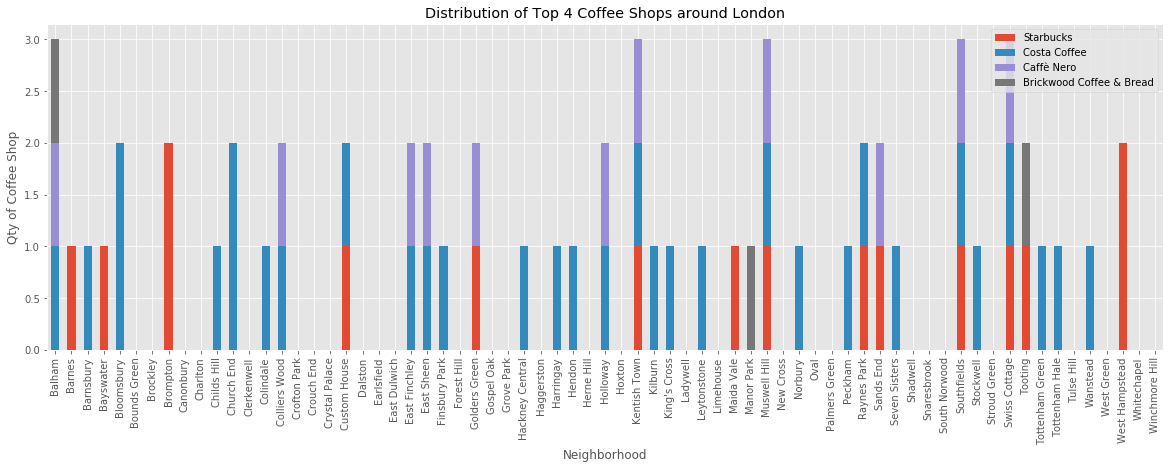

In [33]:
# lets choose only top 4 coffee shop brand for analysis
London_topcoffee2=London_grouped2.loc[:, ['Neighborhood','Starbucks','Costa Coffee','Caffè Nero','Brickwood Coffee & Bread']].set_index('Neighborhood')

London_topcoffee2.plot(kind='bar', figsize=(20, 6), stacked=True)
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Qty of Coffee Shop') # add y-label to the plot
plt.title('Distribution of Top 4 Coffee Shops around London') # add title to the plot

plt.show()


In [44]:
#Compiling total quantity of top 4 coffee shops in all neighborhood
London_top=London_grouped2.loc[:, ['Neighborhood','Starbucks','Costa Coffee','Caffè Nero','Brickwood Coffee & Bread']]
London_top['Total Top 4']=London_top4[['Starbucks','Costa Coffee','Caffè Nero','Brickwood Coffee & Bread']].sum(axis=1)
London_top4=London_top.drop(['Starbucks', 'Costa Coffee','Caffè Nero','Brickwood Coffee & Bread'], axis=1)
London_top4

,Neighborhood,Total Top 4
0,Balham,3
1,Barnes,1
2,Barnsbury,1
3,Bayswater,1
4,Bloomsbury,2
5,Bounds Green,0
6,Brockley,0
7,Brompton,2
8,Canonbury,0
9,Charlton,0


### Combining all necessary data into 1 table, and create cluster using these data

In [188]:
# split into 3 tier (low, medium, high). 
London_coffee1 = pd.merge(London_coffee, London_top4, how='left' , on='Neighborhood').fillna(0)
London_coffee1

London_coffee_final= London_coffee1.merge(London_data[['Neighborhood','Population','Rental per m2']], on='Neighborhood', how='left')
London_coffee_final.head()

# Create normalized reading for each data for clustering
London_coffee_final1=London_coffee_final.drop(['Neighborhood'], 1)
London_coffee_final1_normalized=(London_coffee_final1-London_coffee_final1.min())/(London_coffee_final1.max()-London_coffee_final1.min())
London_coffee_final1_normalized

#Define number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_coffee_final1_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# merge cluster label into dataframe
London_coffee_final.insert(1, 'Cluster Labels', kmeans.labels_)
London_coffee_final3= London_coffee_final.merge(London_data[['Neighborhood','latitude','longitude']], on='Neighborhood', how='left')
London_coffee_final3

,Neighborhood,Cluster Labels,Coffee Shop,Total Top 4,Population,Rental per m2,latitude,longitude
0,Abbey Wood,0,0,0.0,15704,300,51.4876,0.11405
1,Balham,1,7,3.0,14751,969,51.4456,-0.150364
2,Barnes,2,1,1.0,10299,700,51.4719,-0.238744
3,Barnsbury,2,1,1.0,12201,2368,51.5389,-0.114735
4,Bayswater,2,4,1.0,10300,950,51.5123,-0.188385
5,Beckton,0,0,0.0,15141,400,51.5161,0.0594257
6,Bellingham,0,0,0.0,14775,275,51.4311,-0.0245145
7,Blackheath,3,0,0.0,14039,700,51.4663,0.0085624
8,Bloomsbury,1,9,2.0,10892,2045,51.5231,-0.126066
9,Bounds Green,3,2,0.0,13725,335,51.6074,-0.124905


### Plot a map showing cluster locations

In [193]:
#Plot a Cluster Map
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+5))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_coffee_final3['latitude'], London_coffee_final3['longitude'], London_coffee_final3['Neighborhood'], London_coffee_final3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze each created clusters

Cluster 1 showing following conditions:

* Lowest coffee shop density within neighborhoos

* Lowest quantity of top 4 coffee shops within neighborhood

* Middle to high population numbers

* Low range of rental

In [189]:
# Cluster 1 - Most Favorable location
Cluster1 = London_coffee_final3.loc[London_coffee_final3['Cluster Labels'] == 0]
Cluster1

,Neighborhood,Cluster Labels,Coffee Shop,Total Top 4,Population,Rental per m2,latitude,longitude
0,Abbey Wood,0,0,0.0,15704,300,51.4876,0.11405
5,Beckton,0,0,0.0,15141,400,51.5161,0.0594257
6,Bellingham,0,0,0.0,14775,275,51.4311,-0.0245145
10,Brockley,0,2,0.0,17156,538,51.4578,-0.0360868
12,Brunswick Park,0,0,0.0,16394,440,51.6262,-0.14819
16,Childs Hill,0,1,1.0,20049,538,51.563,-0.197249
24,Crofton Park,0,2,0.0,14937,538,51.4552,-0.0366376
30,Earlsfield,0,1,0.0,15448,1292,51.4464,-0.189394
40,Grove Park,0,2,0.0,14648,225,51.4319,0.0212344
41,Grove Park,0,2,0.0,14648,225,51.4319,0.0212344


Cluster 2 showing following conditions:

* Highest coffee shop density within neighborhoos

* Highest quantity of top 4 coffee shops within neighborhood

* Low to middle population numbers

* Low to Middle range of rental

In [190]:
# Cluster 2 - Least Favorable Location
Cluster2 = London_coffee_final3.loc[London_coffee_final3['Cluster Labels'] == 1]
Cluster2

,Neighborhood,Cluster Labels,Coffee Shop,Total Top 4,Population,Rental per m2,latitude,longitude
1,Balham,1,7,3.0,14751,969,51.4456,-0.150364
8,Bloomsbury,1,9,2.0,10892,2045,51.5231,-0.126066
11,Brompton,1,3,2.0,8839,1400,51.4918,-0.178326
17,Church End,1,4,2.0,11516,440,51.6011,-0.19189
18,Church End,1,4,2.0,11516,440,51.6011,-0.19189
19,Church End,1,4,2.0,11516,440,51.6011,-0.19189
20,Church End,1,4,2.0,11516,440,51.6011,-0.19189
23,Colliers Wood,1,4,2.0,10712,1023,51.4183,-0.177863
27,Custom House,1,2,2.0,13411,400,51.5096,0.0282919
32,East Finchley,1,3,2.0,15989,440,51.5872,-0.164814


Cluster 3 showing following conditions:

* Middle coffee shop density within neighborhoos

* Middle quantity of top 4 coffee shops within neighborhood

* Low to middle population numbers

* Low to Middle range of rental

In [191]:
# Cluster 3 - Less Favorable List
Cluster3 = London_coffee_final3.loc[London_coffee_final3['Cluster Labels'] == 2]
Cluster3

,Neighborhood,Cluster Labels,Coffee Shop,Total Top 4,Population,Rental per m2,latitude,longitude
2,Barnes,2,1,1.0,10299,700,51.4719,-0.238744
3,Barnsbury,2,1,1.0,12201,2368,51.5389,-0.114735
4,Bayswater,2,4,1.0,10300,950,51.5123,-0.188385
21,Clerkenwell,2,6,0.0,11490,2368,51.5237,-0.105555
22,Colindale,2,1,1.0,17098,1023,51.5954,-0.24993
25,Crouch End,2,5,0.0,12395,969,51.5787,-0.123599
28,Dalston,2,4,0.0,14727,1184,51.5461,-0.0756793
34,Finsbury Park,2,2,1.0,14358,400,51.5648,-0.106414
35,Forest Hill,2,4,0.0,14854,275,51.4392,-0.0530903
44,Hackney Central,2,4,1.0,12548,1184,51.5471,-0.0568749


Cluster 4 showing following conditions:

* Low coffee shop density within neighborhoos

* Low quantity of top 4 coffee shops within neighborhood

* Low to middle population numbers

* Low to Middle range of rental

In [192]:
# Cluster 4 - More Favorable List
Cluster4 = London_coffee_final3.loc[London_coffee_final3['Cluster Labels'] == 3]
Cluster4

,Neighborhood,Cluster Labels,Coffee Shop,Total Top 4,Population,Rental per m2,latitude,longitude
7,Blackheath,3,0,0.0,14039,700,51.4663,0.0085624
9,Bounds Green,3,2,0.0,13725,335,51.6074,-0.124905
13,Cann Hall,3,0,0.0,13799,300,51.5574,0.0156818
14,Canonbury,3,2,0.0,12072,400,51.5438,-0.0906318
15,Charlton,3,1,0.0,14385,1023,51.4826,0.0365359
26,Crystal Palace,3,1,0.0,12255,225,51.4194,-0.0711328
29,Dollis Hill,3,0,0.0,13425,538,51.552,-0.239021
31,East Dulwich,3,2,0.0,12321,360,51.4586,-0.0727322
36,Fortis Green,3,0,0.0,12488,969,51.591,-0.153421
37,Gipsy Hill,3,0,0.0,13712,300,51.4247,-0.0845885


### Summary of Clusters

Clusters | Coffee Shop Density | Qty of Top 4 Coffee Shop | Population | Rental
------ | ------ | ------ | ------
Cluster 1 | Lowest | Lowest | Middle to High | Low
Cluster 2 | Highest | Highest | Low to Middle | Middle
Cluster 3 | Middle | Middle | Middle | Middle to High
Cluster 4 | Low | Low | Low to Middle| Low to Middle

Clusters | Coffee Shop Density | Qty of Top 4 Coffee Shop | Population | Rental
--- | --- | --- | ---
Cluster 1 | Lowest | Lowest | Middle to High | Low

Clusters | Coffee Shop Density | Qty of Top 4 Coffee Shop | Population
--- | --- | --- | ---
Cluster 1 | Lowest | Lowest | Middle to Hi